In [4]:
#@title File Locations
state_param_file = "../data/us-wa/wa_state_parameters_transpose.csv" #@param {type:"string"}
county_households_file = "../data/us-wa/wa_county_household_demographics.csv" #@param {type:"string"}
county_params_file = "../data/us-wa/wa_county_parameters.csv" #@param {type:"string"}
county_occupation_file = "../data/us-wa/wa_county_occupation_networks.csv"  #@param {type:"string"}

In [5]:
%load_ext autoreload
%autoreload 1
%aimport county_utils

In [6]:
import county_utils as utils
from county_utils import AggregateModel
import numpy as np
import pandas as pd

In [7]:
local_params = {
    "lockdown_days": 35,
    "app_turned_on": 0,
    "custom_occupation_network": 1,
}

In [8]:
model = AggregateModel([state_param_file], county_households_file, county_occupation_file, county_params_file, local_params)

In [6]:
results = model.run_counties([53039,53031,53017,53047])

Batch progress: 100%|██████████| 4/4 [00:56<00:00, 14.02s/it]


In [28]:
import county_utils
model = county_utils.AggregateModel()
params = model.get_county_params(county_fips=53039,params_overrides={
    "n_total":10000,
    "app_turned_on": 0,
    "infectious_rate": 3.67,
    "n_seed_infection": 5})

In [26]:
params.get_param("infectious_rate")

3.67

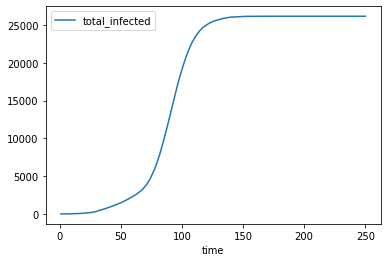

In [7]:
list(results.values())[0][1].plot(x='time', y='total_infected')

In [8]:
model.write_results("results/small_counties")

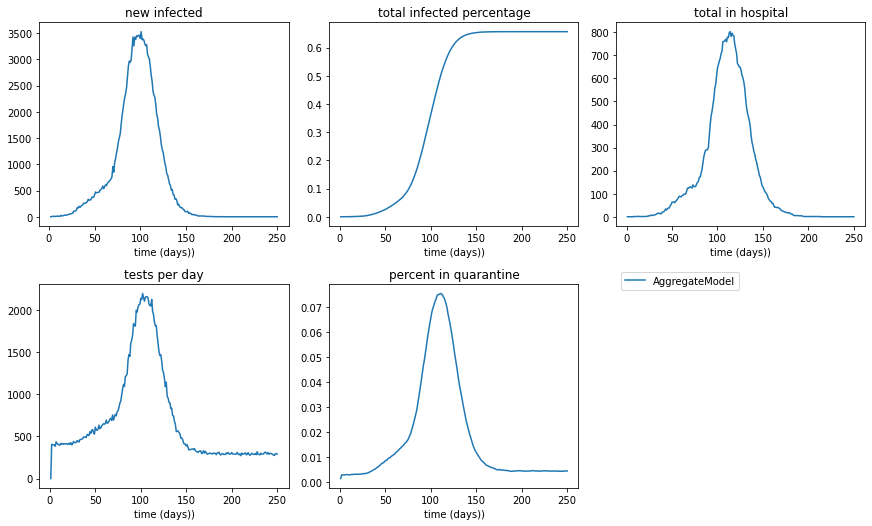

In [9]:
model.plot_results()

In [9]:
params_realistic = {
    "rng_seed" : 1,
    "end_time" : 250,
    # "days_of_interactions": 14,
    "app_turned_on" : 1,
    "allow_clinical_diagnosis": 1,
    "self_quarantine_fraction" : 0.8, # self quarantine on symptoms
    # If we consider an interaction as a "close contact", that is <6ft for >=15min,
    # Most interactions should be caught by the system (in fact it's more likely to have FP than FN).
    # FN rate was 0.08.
    "traceable_interaction_fraction" : 0.92,
    "app_users_fraction": 0.8,
    "quarantine_on_traced": 1,
    "lockdown_days": 35,
     # No household quarantining, not recommended by CDC.
     # https://www.cdc.gov/coronavirus/2019-ncov/php/principles-contact-tracing.html
    "quarantine_household_on_symptoms": 0,
    "quarantine_household_on_positive": 0,
    "quarantine_household_on_traced_positive": 0,
    "hospitalised_daily_interactions": 0,
    "test_insensitive_period": 1,
    "test_order_wait": 1,
    "test_result_wait": 1,
    "retrace_on_positive": 1,
    "trace_on_positive": 1,
    "trace_on_symptoms": 0,
    "test_on_symptoms": 1,
    # "test_on_traced": 1, # We quarantine, but don't test on traced.
    "testing_symptoms_time_on": 0,
    "intervention_start_time": 0,
    "quarantine_length_self": 14, # 7
    "quarantine_length_traced_positive": 7, # 14
    "quarantine_length_traced_symptoms": 7, # 14
    "quarantine_length_positive": 14, # 14
    "quarantine_dropout_self": 0.05,
    "quarantine_dropout_traced_positive": 0.1,
    "quarantine_dropout_traced_symptoms": 0.1,
    "quarantine_dropout_positive": 0.02,
    "infectious_rate": 5.64,
    "mean_random_interactions_child": 4,
    "sd_random_interactions_child": 4,
    "mean_random_interactions_adult": 4,
    "sd_random_interactions_adult": 4,
    # "mild_infectious_factor": 0.7,
    "lockdown_occupation_multiplier_primary_network": 0.1, # 0.22
    "lockdown_occupation_multiplier_secondary_network": 0.1,
    "lockdown_occupation_multiplier_retired_network": 0.4,
    "lockdown_occupation_multiplier_elderly_network": 0.5,
    "lockdown_occupation_multiplier_working_network": 0.6,
    "lockdown_random_network_multiplier": 0.4,
    "lockdown_house_interaction_multiplier": 2, #1.5
    "relative_transmission_household" : 2,
    "relative_transmission_occupation" : 1,
    "relative_transmission_random" : 1,
    # From https://gwhwi.org/estimator-613404.html
    "manual_trace_on": 0,
    "manual_trace_on_hospitalization": 1,
    "manual_trace_on_positive": 0,
    "manual_trace_delay": 1,
    "manual_traceable_fraction_household": 1,
    "manual_traceable_fraction_occupation": 0.8,
    "manual_traceable_fraction_random": 0.05,
    "manual_trace_exclude_app_users": 0,
    "manual_trace_n_workers": 30,
    "manual_trace_interviews_per_worker_day": 6,
    "manual_trace_notifications_per_worker_day": 12,
}

In [10]:
r_app_on = model.run_county(53039,params_overrides={"app_turned_on":1,"app_turn_on_time":0,
    "custom_occupation_network": 0,})


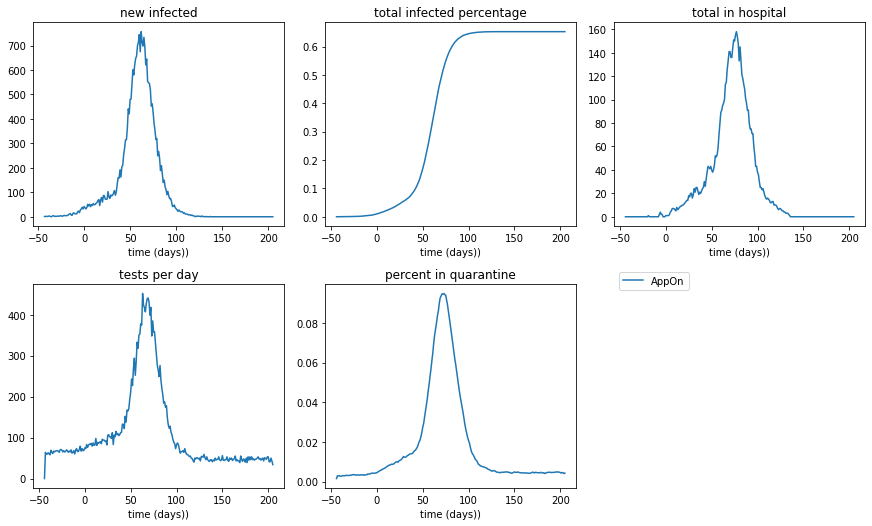

In [11]:
utils.sim_display([r_app_on],["AppOn"])

In [12]:
r_app_on[0]

{'county_fips': '00000',
 'lockdown_days': 35.0,
 'app_users_fraction': 0.8,
 'custom_occupation_network': 0,
 'study_name': '0',
 'Index': 0,
 'household_size_1': 4830.0,
 'household_size_2': 6778.0,
 'household_size_3': 2150.0,
 'household_size_4': 1768.0,
 'household_size_5': 911.0,
 'household_size_6': 382.0,
 'population_0_9': 5236.0,
 'population_10_19': 5659.0,
 'population_20_29': 3966.0,
 'population_30_39': 4501.0,
 'population_40_49': 5394.0,
 'population_50_59': 6635.0,
 'population_60_69': 4769.0,
 'population_70_79': 2753.0,
 'population_80': 1540.0,
 'n_total': 40453.0,
 'manual_trace_n_workers': 6.0,
 'rng_seed': 1.0,
 'param_id': 1.0,
 'app_users_fraction_0_9': 0.23,
 'app_users_fraction_10_19': 0.75,
 'app_users_fraction_20_29': 0.96,
 'app_users_fraction_30_39': 0.92,
 'app_users_fraction_40_49': 0.92,
 'app_users_fraction_50_59': 0.79,
 'app_users_fraction_60_69': 0.66,
 'app_users_fraction_70_79': 0.53,
 'app_users_fraction_80': 0.53,
 'end_time': 250.0,
 'lockdown

In [28]:
def diff_params(params, global_params=pd.read_csv("../tests/data/baseline_parameters.csv"
)):
  local_params = pd.DataFrame(params,index=[0])
  if isinstance(global_params, dict):
    global_params = pd.DataFrame(global_params,index=[0])
  for col in sorted(local_params.columns):
    if col not in global_params.columns:
      continue
    if global_params[col][0] != local_params[col][0]:
      print(f"{col} {global_params[col][0]} {local_params[col][0]}")
diff_params(r_app_on[0])

app_turn_on_time 10000 0
app_users_fraction_0_9 0.09 0.23
app_users_fraction_10_19 0.8 0.75
app_users_fraction_20_29 0.97 0.96
app_users_fraction_30_39 0.96 0.92
app_users_fraction_40_49 0.94 0.92
app_users_fraction_50_59 0.86 0.79
app_users_fraction_60_69 0.7 0.66
app_users_fraction_70_79 0.48 0.53
app_users_fraction_80 0.32 0.53
end_time 200 250.0
household_size_1 7452 4830.0
household_size_2 9936 6778.0
household_size_3 4416 2150.0
household_size_4 4140 1768.0
household_size_5 1104 911.0
household_size_6 552 382.0
lockdown_house_interaction_multiplier 1.5 2.0
lockdown_occupation_multiplier_elderly_network 0.22 0.5
lockdown_occupation_multiplier_primary_network 0.22 0.1
lockdown_occupation_multiplier_retired_network 0.22 0.4
lockdown_occupation_multiplier_secondary_network 0.22 0.1
lockdown_occupation_multiplier_working_network 0.22 0.6
lockdown_random_network_multiplier 0.22 0.4
manual_trace_n_workers 300 329894.0
mean_random_interactions_child 2 4.0
n_total 1000000 40453.0
populati

In [20]:
r_app_off = model.run_county(53039,params_overrides={"app_turned_on":0,"app_turn_on_time":1000,
    "custom_occupation_network": 0,})

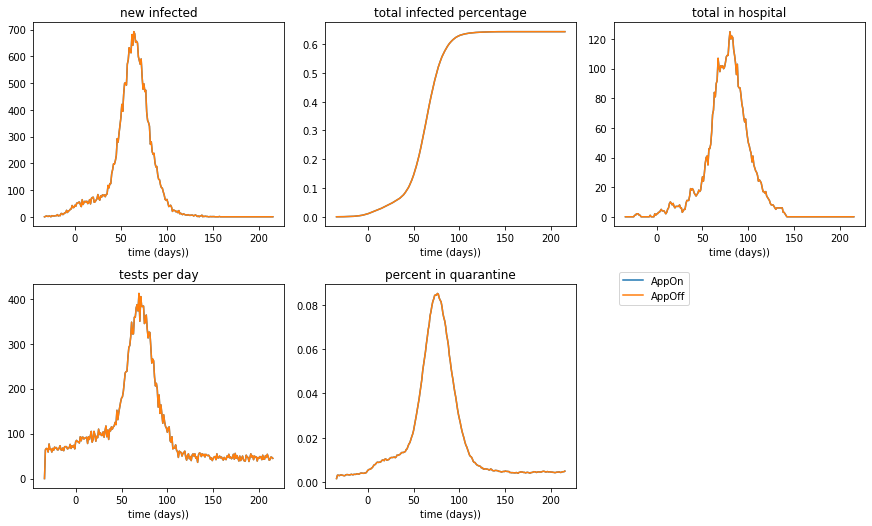

In [21]:
utils.sim_display([r_app_on, r_app_off],["AppOn","AppOff"])

In [29]:
diff_params(r_app_off[0])

app_turn_on_time 10000 1000
app_users_fraction_0_9 0.09 0.23
app_users_fraction_10_19 0.8 0.75
app_users_fraction_20_29 0.97 0.96
app_users_fraction_30_39 0.96 0.92
app_users_fraction_40_49 0.94 0.92
app_users_fraction_50_59 0.86 0.79
app_users_fraction_60_69 0.7 0.66
app_users_fraction_70_79 0.48 0.53
app_users_fraction_80 0.32 0.53
end_time 200 250.0
household_size_1 7452 4830.0
household_size_2 9936 6778.0
household_size_3 4416 2150.0
household_size_4 4140 1768.0
household_size_5 1104 911.0
household_size_6 552 382.0
lockdown_house_interaction_multiplier 1.5 2.0
lockdown_occupation_multiplier_elderly_network 0.22 0.5
lockdown_occupation_multiplier_primary_network 0.22 0.1
lockdown_occupation_multiplier_retired_network 0.22 0.4
lockdown_occupation_multiplier_secondary_network 0.22 0.1
lockdown_occupation_multiplier_working_network 0.22 0.6
lockdown_random_network_multiplier 0.22 0.4
manual_trace_n_workers 300 329894.0
mean_random_interactions_child 2 4.0
n_total 1000000 40453.0
popul

In [10]:
merged_params = pd.read_csv("results/small_counties/merged_params.csv").loc[0].to_dict()
merged_results = pd.read_csv("results/small_counties/merged_results.csv")

In [11]:
merged_results

,time,lockdown,test_on_symptoms,app_turned_on,total_infected,total_infected_0_9,total_infected_10_19,total_infected_20_29,total_infected_30_39,total_infected_40_49,...,hospital_to_critical_total,n_quarantine_infected,n_quarantine_recovered,n_quarantine_app_user,n_quarantine_app_user_infected,n_quarantine_app_user_recovered,n_quarantine_events,n_quarantine_release_events,n_quarantine_events_app_user,n_quarantine_release_events_app_user
0,1,0,4,0,20,4,3,2,1,4,...,0,0,0,277,0,0,384,0,277,0
1,2,0,4,0,20,4,3,2,1,4,...,0,1,0,545,1,0,386,25,291,23
2,3,0,4,0,23,4,3,2,2,4,...,0,2,0,546,2,0,385,375,266,265
3,4,0,4,0,32,5,4,3,4,6,...,0,3,0,512,3,0,384,394,265,299
4,5,0,4,0,38,5,4,4,5,6,...,0,3,0,527,3,0,361,371,269,254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,246,0,4,0,166310,8749,17831,20839,19124,23681,...,633,853,853,803,633,633,360,372,267,270
246,247,0,4,0,166310,8749,17831,20839,19124,23681,...,633,894,894,826,659,659,382,345,268,245
247,248,0,4,0,166310,8749,17831,20839,19124,23681,...,633,912,912,798,641,641,371,360,249,277
248,249,0,4,0,166310,8749,17831,20839,19124,23681,...,633,901,901,795,634,634,376,384,267,270


In [13]:
merged_params["time_offset"] = 0

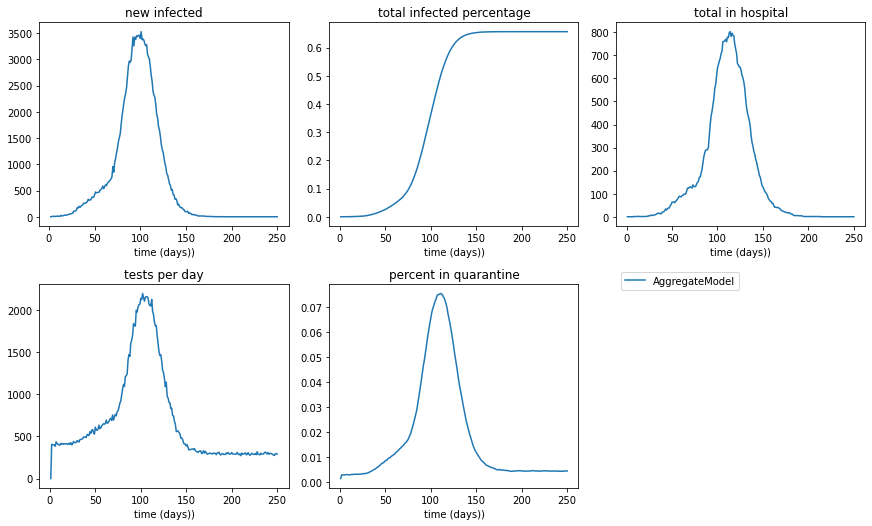

In [14]:
utils.sim_display([[merged_params, merged_results]],["AggregateModel"])

In [15]:
sim_results = utils.read_results("results/us-wa")

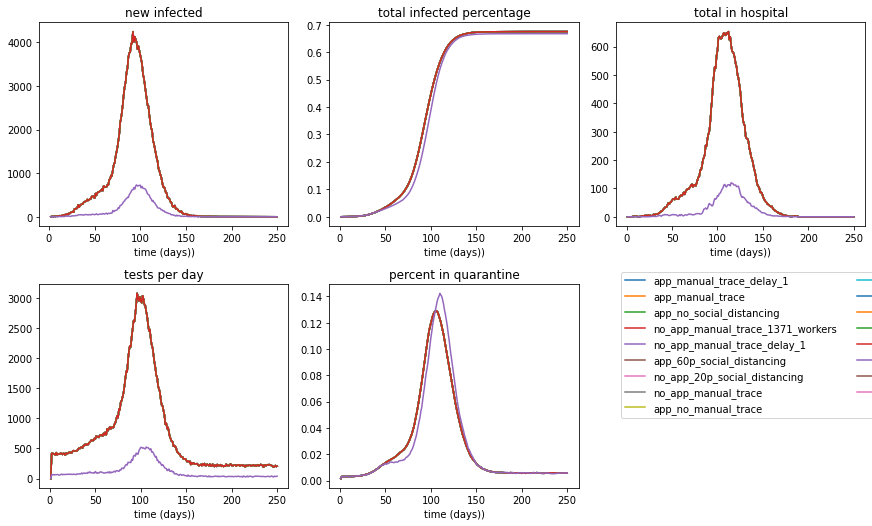

In [16]:
utils.sim_display(sim_results[0], sim_results[1])

In [17]:
results_no_custom_occu = model.run_county(model.counties[0], {"custom_occupation_network": 0})

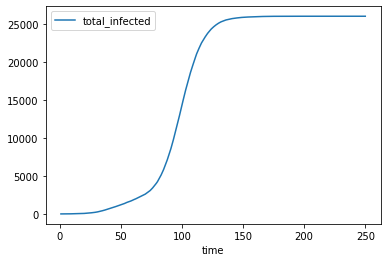

In [18]:
results_no_custom_occu[1].plot(x='time', y='total_infected')

In [19]:
np.where(list(results.values())[0][1].lockdown == 1), np.where(results_no_custom_occu[1].lockdown == 1)

((array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
         49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
         66]),),
 (array([35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
         52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
         69]),))